# Strategy

Choose stocks which are underperforming the S&P 500 according to their variation from the OLS regression between the stock and SPY. Use a pair of thresholds for the z-score and determine the cumulative returns.

In [1]:
import yfinance as yf
import pandas as pd

# Read and print the stock tickers that make up the S&P 500 - from https://gist.github.com/quantra-go-algo/ac5180bf164a7894f70969fa563627b2

tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
look_back_window = 10 * 7
data_look_back = '6mo'

tickers

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [2]:
sp_500_data = yf.download(tickers["Symbol"].to_list(), period=data_look_back, interval='1h',
                          auto_adjust=True)
sp_500_data

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (period=6mo)')
['BRK.B']: YFPricesMissingError('possibly delisted; no price data found  (period=6mo) (Yahoo error = "No data found, symbol may be delisted")')


Price                     Adj Close             Close                          \
Ticker                         BF.B BRK.B           A        AAPL        ABBV   
2024-09-09 13:30:00+00:00       NaN   NaN  138.809998  218.875000  194.949997   
2024-09-09 14:30:00+00:00       NaN   NaN  138.389999  218.960007  195.720001   
2024-09-09 15:30:00+00:00       NaN   NaN  139.110001  220.203903  196.100006   
2024-09-09 16:30:00+00:00       NaN   NaN  138.824997  220.839996  196.156204   
2024-09-09 17:30:00+00:00       NaN   NaN  138.029999  217.169998  196.300003   
...                             ...   ...         ...         ...         ...   
2025-03-07 16:30:00+00:00       NaN   NaN  125.394997  239.289993  213.319901   
2025-03-07 17:30:00+00:00       NaN   NaN  126.724998  240.414398  214.373001   
2025-03-07 18:30:00+00:00       NaN   NaN  127.269997  239.649994  213.949997   
2025-03-07 19:30:00+00:00       NaN   NaN  127.495003  238.811401  214.669998   
2025-03-07 20:30:00+00:00       NaN   NaN  126.690002  239.070007  214.179993   

Price                                                                      \
Ticker                           ABNB         ABT        ACGL         ACN   
2024-09-09 13:30:00+00:00  116.870003  115.510002  111.415001  339.950012   
2024-09-09 14:30:00+00:00  116.184998  115.940002  111.589996  339.445007   
2024-09-09 15:30:00+00:00  117.105003  116.349998  112.150002  341.579987   
2024-09-09 16:30:00+00:00  117.629898  116.525002  112.264999  341.899994   
2024-09-09 17:30:00+00:00  117.489998  116.449997  112.129997  340.698395   
...                               ...         ...         ...         ...   
2025-03-07 16:30:00+00:00  130.949997  136.000000   90.820000  337.309998   
2025-03-07 17:30:00+00:00  132.479996  136.824997   91.230003  340.454987   
2025-03-07 18:30:00+00:00  134.354996  137.274994   91.334999  341.720001   
2025-03-07 19:30:00+00:00  133.949997  137.225006   91.430000  340.929993   
2025-03-07 20:30:00+00:00  134.389999  137.110001   91.040001  342.179993   

Price                                  ...   Volume                      \
Ticker                           ADBE  ...      WTW        WY      WYNN   
2024-09-09 13:30:00+00:00  570.489990  ...      0.0  595791.0  194470.0   
2024-09-09 14:30:00+00:00  568.205017  ...  30333.0  243424.0  162059.0   
2024-09-09 15:30:00+00:00  572.159973  ...  25134.0  207791.0  126717.0   
2024-09-09 16:30:00+00:00  573.929993  ...  33480.0  177430.0  242000.0   
2024-09-09 17:30:00+00:00  567.549988  ...  68360.0  183226.0  110390.0   
...                               ...  ...      ...       ...       ...   
2025-03-07 16:30:00+00:00  443.290009  ...  52973.0  514523.0  218533.0   
2025-03-07 17:30:00+00:00  446.209991  ...  53894.0  351777.0  168252.0   
2025-03-07 18:30:00+00:00  450.599915  ...  44586.0  409864.0  244072.0   
2025-03-07 19:30:00+00:00  450.760010  ...  33911.0  584731.0  222922.0   
2025-03-07 20:30:00+00:00  449.380005  ...  80593.0  698146.0  311493.0   

Price                                                                          \
Ticker                           XEL        XOM       XYL       YUM       ZBH   
2024-09-09 13:30:00+00:00   262360.0  3480333.0  231777.0  211356.0  245707.0   
2024-09-09 14:30:00+00:00   147319.0  3017606.0   74784.0  151969.0  188845.0   
2024-09-09 15:30:00+00:00   261741.0  2304761.0   62441.0  117211.0  151348.0   
2024-09-09 16:30:00+00:00   204356.0  1901616.0   65413.0  158757.0  111291.0   
2024-09-09 17:30:00+00:00   146870.0  1580271.0   77682.0  241970.0  157687.0   
...                              ...        ...       ...       ...       ...   
2025-03-07 16:30:00+00:00   392459.0  1978236.0  109684.0  295787.0  172616.0   
2025-03-07 17:30:00+00:00   269254.0  1497116.0  188180.0  275950.0  169847.0   
2025-03-07 18:30:00+00:00   254102.0  1341543.0   84561.0  333226.0  242512.0   
2025-03-07 19:30:00+00:00   369855.0  1262282.0  100876.0  477254.0  323429.0

In [3]:
sp_500_close_data = sp_500_data["Close"].dropna(axis=1, how="all").ffill()
sp_500_close_data

eastern_indices = sp_500_close_data.index.tz_convert('US/Eastern')
eastern_indices

DatetimeIndex(['2024-09-09 09:30:00-04:00', '2024-09-09 10:30:00-04:00',
               '2024-09-09 11:30:00-04:00', '2024-09-09 12:30:00-04:00',
               '2024-09-09 13:30:00-04:00', '2024-09-09 14:30:00-04:00',
               '2024-09-09 15:30:00-04:00', '2024-09-10 09:30:00-04:00',
               '2024-09-10 10:30:00-04:00', '2024-09-10 11:30:00-04:00',
               ...
               '2025-03-06 13:30:00-05:00', '2025-03-06 14:30:00-05:00',
               '2025-03-06 15:30:00-05:00', '2025-03-07 09:30:00-05:00',
               '2025-03-07 10:30:00-05:00', '2025-03-07 11:30:00-05:00',
               '2025-03-07 12:30:00-05:00', '2025-03-07 13:30:00-05:00',
               '2025-03-07 14:30:00-05:00', '2025-03-07 15:30:00-05:00'],
              dtype='datetime64[ns, US/Eastern]', length=862, freq=None)

In [4]:
sp_500_close_data.set_index(eastern_indices, inplace=True)

In [5]:
sp_500_close_data.index.hour

Index([ 9, 10, 11, 12, 13, 14, 15,  9, 10, 11,
       ...
       13, 14, 15,  9, 10, 11, 12, 13, 14, 15],
      dtype='int32', length=862)

In [6]:
tickers["GICS Sector"].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Utilities', 'Financials', 'Materials', 'Consumer Discretionary',
       'Real Estate', 'Communication Services', 'Consumer Staples',
       'Energy'], dtype=object)

In [7]:
sectors_to_tickers = {
    "Industrials": "SP500-20",
    "Health Care": "SP500-35",
}

yf.download(["SP500-20", "SP500-35"], period=data_look_back, interval='1h',
                          auto_adjust=True)

[*********************100%***********************]  2 of 2 completed

2 Failed downloads:
['SP500-35', 'SP500-20']: YFPricesMissingError('possibly delisted; no price data found  (period=6mo) (Yahoo error = "No data found, symbol may be delisted")')


Empty DataFrame
Columns: [(Adj Close, SP500-20), (Adj Close, SP500-35), (Close, SP500-20), (Close, SP500-35), (High, SP500-20), (High, SP500-35), (Low, SP500-20), (Low, SP500-35), (Open, SP500-20), (Open, SP500-35), (Volume, SP500-20), (Volume, SP500-35)]
Index: []

In [8]:
wednesday_first_hour_closing_px = sp_500_close_data[
    (sp_500_close_data.index.weekday == 2) & (sp_500_close_data.index.hour == 9)]
wednesday_first_hour_closing_px

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2024-09-11 09:30:00-04:00,134.975006,219.250000,194.169998,113.227501,114.907402,109.269997,342.910004,563.405029,216.100006,58.455002,...,283.519989,30.340000,74.974998,63.209999,108.535004,126.769997,131.289993,103.510002,328.769989,186.884995
2024-09-18 09:30:00-04:00,138.429993,220.735001,193.860001,123.320000,115.714996,113.709999,334.320007,508.700012,224.729996,60.369999,...,293.029999,33.099998,78.860001,64.540001,113.900002,132.979996,132.789993,105.730003,349.500000,195.320007
2024-09-25 09:30:00-04:00,141.520004,226.384995,192.740005,130.730698,112.320000,112.820000,337.940002,521.690002,226.490005,58.980000,...,290.679993,33.630001,84.010002,64.309998,115.269997,133.770004,132.570007,107.169998,364.839996,194.149994
2024-10-02 09:30:00-04:00,146.440002,225.419998,195.925003,125.529999,113.050003,113.440002,354.459991,509.829895,228.289993,59.380001,...,298.894989,33.630001,100.190002,65.209999,121.769997,134.529907,139.119995,106.040001,367.364990,193.720001
2024-10-09 09:30:00-04:00,144.470001,227.100006,192.360001,133.434998,114.709999,111.235001,362.406006,493.160004,230.520004,57.450001,...,293.160004,32.900002,103.260002,62.630001,121.400002,135.070007,135.080002,101.620003,372.265015,187.229996
2024-10-16 09:30:00-04:00,140.990005,230.729706,189.660004,135.934998,119.059998,108.650002,370.279999,502.704987,229.865005,58.000099,...,292.470001,33.345001,100.739998,63.790001,121.000000,137.309479,133.300003,105.224998,378.799988,195.009995
2024-10-23 09:30:00-04:00,132.350006,234.720001,188.229996,134.789993,116.370003,106.805000,370.575012,489.179993,228.300003,55.630001,...,290.720001,31.709999,98.660004,63.945000,120.419998,132.455994,134.673706,104.139999,370.535004,188.445007
2024-10-30 09:30:00-04:00,133.455002,231.860001,193.729996,138.229996,113.620003,105.125000,354.262512,489.309998,232.259995,56.360001,...,293.429993,31.670000,98.650002,62.759998,117.500000,130.149994,133.904999,109.129997,382.190002,182.384995
2024-11-06 09:30:00-05:00,137.634995,225.651306,203.309998,141.464996,116.010002,100.699997,355.179993,504.265015,224.850006,52.174999,...,313.309998,31.500000,86.953201,66.089996,121.364998,123.419998,132.070007,109.559998,385.515015,173.259995
2024-11-13 09:30:00-05:00,133.440002,223.210007,170.932495,134.149994,116.214996,100.830002,364.459991,528.659973,215.220001,51.630001,...,316.670013,30.950001,85.610001,68.760002,119.300003,124.449997,135.914993,109.305000,400.820007,175.279999


In [9]:
sp_500_close_data

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2024-09-09 09:30:00-04:00,138.809998,218.875000,194.949997,116.870003,115.510002,111.415001,339.950012,570.489990,217.490005,59.875000,...,292.054993,30.254999,77.150002,62.970001,114.080002,129.350006,133.429993,105.730003,325.600006,192.214996
2024-09-09 10:30:00-04:00,138.389999,218.960007,195.720001,116.184998,115.940002,111.589996,339.445007,568.205017,217.309998,59.610001,...,292.970001,30.320000,77.129997,63.189999,115.345001,129.304993,133.024994,105.565002,325.029999,192.570007
2024-09-09 11:30:00-04:00,139.110001,220.203903,196.100006,117.105003,116.349998,112.150002,341.579987,572.159973,218.479996,59.830002,...,294.049988,30.360001,77.389999,63.340000,115.860001,129.600006,132.789993,105.919998,327.049988,193.134995
2024-09-09 12:30:00-04:00,138.824997,220.839996,196.156204,117.629898,116.525002,112.264999,341.899994,573.929993,218.369995,59.865002,...,294.730011,30.365000,77.360001,63.485001,115.930000,129.610001,132.785004,106.199997,327.160004,193.089996
2024-09-09 13:30:00-04:00,138.029999,217.169998,196.300003,117.489998,116.449997,112.129997,340.698395,567.549988,217.401596,59.825001,...,293.980011,30.310101,77.110001,63.560001,115.779999,129.380005,132.904999,105.830002,327.209991,192.533997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-07 11:30:00-05:00,125.394997,239.289993,213.319901,130.949997,136.000000,90.820000,337.309998,443.290009,220.897507,49.965000,...,328.529999,30.245001,86.639999,67.860001,109.680000,127.610001,161.615005,106.669998,288.000000,168.970001
2025-03-07 12:30:00-05:00,126.724998,240.414398,214.373001,132.479996,136.824997,91.230003,340.454987,446.209991,222.580002,49.560001,...,330.279999,30.514999,87.794998,68.139999,109.525497,129.115005,162.625000,107.485001,292.089996,170.740005
2025-03-07 13:30:00-05:00,127.269997,239.649994,213.949997,134.354996,137.274994,91.334999,341.720001,450.599915,225.804993,49.445000,...,331.290009,30.655001,88.000000,68.010002,109.650002,129.809998,162.720001,108.044998,292.429993,170.039993
2025-03-07 14:30:00-05:00,127.495003,238.811401,214.669998,133.949997,137.225006,91.430000,340.929993,450.760010,225.770004,49.494999,...,331.799988,30.770000,88.339996,67.720001,109.254997,130.365005,162.759995,107.434998,293.109985,170.309998


In [14]:
# F, PTC, NVDA

# PTC

# bought 1 share for $168.84
start_datetime = pd.to_datetime("2025-02-10 09:30-05:00")
sp_500_close_data["PTC"].loc[start_datetime:]

2025-02-10 09:30:00-05:00    168.600006
2025-02-10 10:30:00-05:00    167.699997
2025-02-10 11:30:00-05:00    166.850006
2025-02-10 12:30:00-05:00    166.479996
2025-02-10 13:30:00-05:00    166.729996
                                ...    
2025-03-07 11:30:00-05:00    158.470001
2025-03-07 12:30:00-05:00    160.350006
2025-03-07 13:30:00-05:00    162.205002
2025-03-07 14:30:00-05:00    161.979996
2025-03-07 15:30:00-05:00    162.649994
Name: PTC, Length: 133, dtype: float64

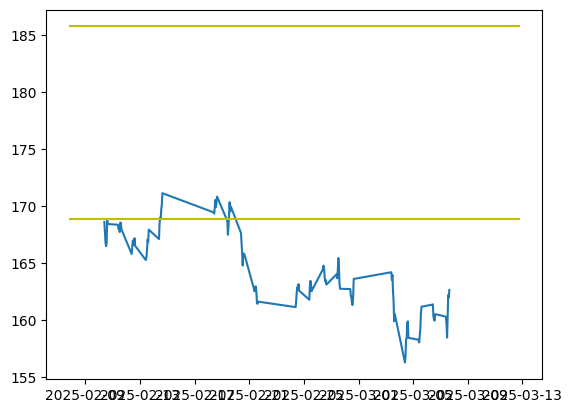

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(sp_500_close_data["PTC"].loc[start_datetime:])
ax.hlines(y=168.84, xmin=20127, xmax=20160, color='y')
ax.hlines(y=185.79, xmin=20127, xmax=20160, color='y')

In [48]:
(sp_500_close_data["PTC"].loc[start_datetime:] > 168.84 * 1.01).astype(int).sum()

3

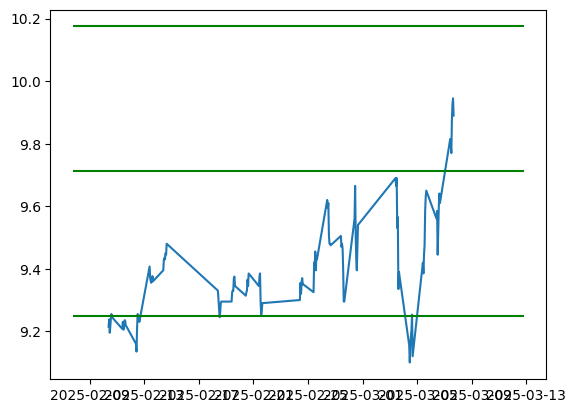

In [57]:
fig, ax = plt.subplots()
ax.plot(sp_500_close_data["F"].loc[start_datetime:])
ax.hlines(y=9.25, xmin=20127, xmax=20160, color='g')
ax.hlines(y=9.25 * 1.05, xmin=20127, xmax=20160, color='g')
ax.hlines(y=10.27, xmin=20127, xmax=20160, color='g')

In [55]:
(sp_500_close_data["F"].loc[start_datetime:] > 9.25 * 1.05).astype(int).sum()

7

In [60]:
sp_500_close_data["F"].loc[start_datetime:][sp_500_close_data["F"].loc[start_datetime:] > 9.25 * 1.05]

2025-03-07 09:30:00-05:00    9.8150
2025-03-07 10:30:00-05:00    9.7988
2025-03-07 11:30:00-05:00    9.7700
2025-03-07 12:30:00-05:00    9.8770
2025-03-07 13:30:00-05:00    9.9280
2025-03-07 14:30:00-05:00    9.9450
2025-03-07 15:30:00-05:00    9.8900
Name: F, dtype: float64

In [56]:
9.25 * 1.05

9.7125

In [5]:
sp_500_recent_data = yf.download(tickers["Symbol"].to_list(), period='1d', interval='1h',
                                 auto_adjust=True)
sp_500_recent_data

[*****                 11%                       ]  54 of 503 completed

KeyboardInterrupt: 

In [5]:
sp_500_close_data

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2024-09-09 09:30:00-04:00,138.809998,218.875000,194.949997,116.870003,115.510002,111.415001,339.950012,570.489990,217.490005,59.875000,...,292.054993,30.254999,77.150002,62.970001,114.080002,129.350006,133.429993,105.730003,325.600006,192.214996
2024-09-09 10:30:00-04:00,138.389999,218.960007,195.720001,116.184998,115.940002,111.589996,339.445007,568.205017,217.309998,59.610001,...,292.970001,30.320000,77.129997,63.189999,115.345001,129.304993,133.024994,105.565002,325.029999,192.570007
2024-09-09 11:30:00-04:00,139.110001,220.203903,196.100006,117.105003,116.349998,112.150002,341.579987,572.159973,218.479996,59.830002,...,294.049988,30.360001,77.389999,63.340000,115.860001,129.600006,132.789993,105.919998,327.049988,193.134995
2024-09-09 12:30:00-04:00,138.824997,220.839996,196.156204,117.629898,116.525002,112.264999,341.899994,573.929993,218.369995,59.865002,...,294.730011,30.365000,77.360001,63.485001,115.930000,129.610001,132.785004,106.199997,327.160004,193.089996
2024-09-09 13:30:00-04:00,138.029999,217.169998,196.300003,117.489998,116.449997,112.129997,340.698395,567.549988,217.401596,59.825001,...,293.980011,30.310101,77.110001,63.560001,115.779999,129.380005,132.904999,105.830002,327.209991,192.533997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-07 11:30:00-05:00,125.394997,239.289993,213.319901,130.949997,136.000000,90.820000,337.309998,443.290009,220.897507,49.965000,...,328.529999,30.245001,86.639999,67.860001,109.680000,127.610001,161.615005,106.669998,288.000000,168.970001
2025-03-07 12:30:00-05:00,126.724998,240.414398,214.373001,132.479996,136.824997,91.230003,340.454987,446.209991,222.580002,49.560001,...,330.279999,30.514999,87.794998,68.139999,109.525497,129.115005,162.625000,107.485001,292.089996,170.740005
2025-03-07 13:30:00-05:00,127.269997,239.649994,213.949997,134.354996,137.274994,91.334999,341.720001,450.599915,225.804993,49.445000,...,331.290009,30.655001,88.000000,68.010002,109.650002,129.809998,162.720001,108.044998,292.429993,170.039993
2025-03-07 14:30:00-05:00,127.495003,238.811401,214.669998,133.949997,137.225006,91.430000,340.929993,450.760010,225.770004,49.494999,...,331.799988,30.770000,88.339996,67.720001,109.254997,130.365005,162.759995,107.434998,293.109985,170.309998


In [6]:
mean_std_pairs = []

for ticker in sp_500_close_data.columns:
    mean_std_pairs.append((sp_500_close_data[ticker].mean(), sp_500_close_data[ticker].std()))


mean_std_pairs

[(138.61138036245535, 6.6359320552823275),
 (234.33130976772088, 9.673806696669086),
 (187.00841380603904, 11.80949126653775),
 (134.13357704144897, 7.336440747190584),
 (119.39544777748479, 7.68383207630065),
 (99.26412454945859, 8.460378109094293),
 (360.3564303015335, 13.710403283391303),
 (480.67255414002454, 40.33991727317869),
 (220.9458311041104, 8.712286646316636),
 (52.97632633837636, 4.440202333276373),
 (295.77331426138113, 11.128199495873126),
 (290.6501586984869, 15.789661433564588),
 (90.98109072267042, 4.565491475252028),
 (98.647204131372, 4.0985411255797635),
 (14.136829566513025, 3.0161958243866667),
 (107.74852498667423, 3.7378648348384957),
 (75.11410476436748, 2.4307963762131077),
 (206.5354073473583, 10.772652030683908),
 (297.28383896688297, 16.66775496347741),
 (96.33374988175323, 6.596580560559372),
 (92.44126310591908, 9.917115022338352),
 (220.76746660484793, 17.97645208219297),
 (192.26791077368222, 5.752482852482947),
 (137.3633813437619, 7.105876053508319)

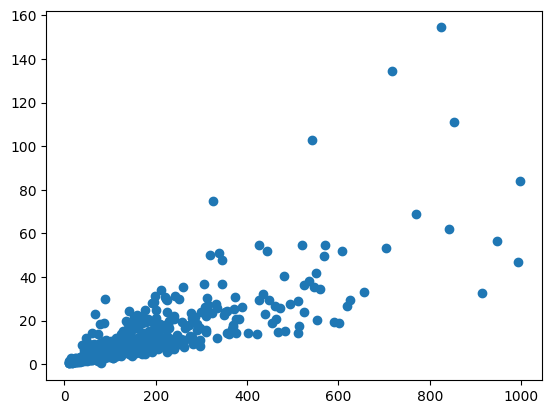

In [9]:
import matplotlib.pyplot as plt

plt.scatter([x[0] for x in mean_std_pairs if x[0] < 1000], [x[1] for x in mean_std_pairs if x[0] < 1000])
plt.show()

In [13]:
mean_std_tuples = []
for ticker in sp_500_close_data.columns:
    mean_std_tuples.append(
        (1 / sp_500_close_data[ticker].iloc[-100:].std(), ticker)
        #(sp_500_close_data[ticker].iloc[-100:].mean() / sp_500_close_data[ticker].iloc[-100:].std(), ticker)
    )

sorted(mean_std_tuples)

[(0.007313221953264696, 'BKNG'),
 (0.009122330306389505, 'NVR'),
 (0.013300228152579446, 'AZO'),
 (0.015207437085348736, 'FICO'),
 (0.016859582891191143, 'AXON'),
 (0.020313320404338756, 'TPL'),
 (0.023247050347938947, 'MPWR'),
 (0.023984436206712374, 'NFLX'),
 (0.026078974792540656, 'NOW'),
 (0.02672427092884494, 'CEG'),
 (0.0273067608584615, 'URI'),
 (0.028407330544198927, 'TSLA'),
 (0.029227773000171094, 'CRWD'),
 (0.03109695138572534, 'GS'),
 (0.034622022914178055, 'KLAC'),
 (0.034899857413707484, 'META'),
 (0.03755312895139628, 'ERIE'),
 (0.03819746372379227, 'ORLY'),
 (0.03921924289485685, 'GEV'),
 (0.03994917216175396, 'SNPS'),
 (0.04037652979918099, 'ISRG'),
 (0.040475902065435984, 'PH'),
 (0.04073602688559189, 'COST'),
 (0.04231158333063993, 'LLY'),
 (0.04235063417971538, 'TDG'),
 (0.04565674890050671, 'LII'),
 (0.04672167514813232, 'MLM'),
 (0.046809415851056475, 'MTD'),
 (0.04835047049674059, 'EPAM'),
 (0.05000371908891036, 'EQIX'),
 (0.05046872236846269, 'TFX'),
 (0.0505729